
# Python-based Multilayer Neural Network based on Andrew Ng's Intro to Machine Learning Course


This notebook intends to provide a readily accessible and scalable feed forward neural network model for learning and expirimentaiton.  I've done my current best to make the algorithms and mathematics as clear and straightforward as possible relative to Andrew Ng's Coursera course explanation of neural networks.   

This notebook generalizes Dr. Ng's ML Coursera neural network problem in the Lesson 4 exercises.  Thanks and recognition goes to [jdwittenauer's](https://github.com/jdwittenauer/ipython-notebooks/tree/master/notebooks/ml) for his Python port of Dr. Ng's Octave exercises. I doubt I'd have gotten started without his code as a baseline.  

This work creates a generalized way of training arbitrarily-sized hidden layers to recognize 20x20 pixel hand-written number mnist data.  While I haven't tried it yet, I would expect the code to be easily modifiable to use cases with other input/output layer requirements.

It uses my current best understanding of Numpy primarily, with a bit of helping functions from Scikit Learn along with SciPy's minimize optimizer. 

I've achieved up to a 94.8% accuracy on a test set so far with zero regularization.

In [1]:
import numpy as np
#from scipy.optimize import minimize

Dataset comes from Dr. Ng's coursework. It is composed of 5000 20 pixel x 20 pixel images of handwritten digits.  The 400 pixels for each image are represented as a flattened row in the 'X' matrix.  Each of these 5000 samples has an associated label (the 'y' matrix) that specifies the specific handwritten digit represented in the corresponding X row. 

To represent the Y matrix in a way that facilitates prediction of the handwritten value by the network, the following function creates a corresponding one_hot representation of the label data input.  This allows the network's output/hypothesis to conveniently communicate its handwriten digit prediction as an array's whose highest score index represents the prediction.

In [2]:
from sklearn.preprocessing import OneHotEncoder

#y = 5000x1 matrix, returns a 5000x10 matrix

def one_hot(y):
    encoder = OneHotEncoder(sparse=False)
    return encoder.fit_transform(y)


## Activation Functions

Each 'neuron' is represented by a [logistic function node](https://en.wikipedia.org/wiki/Logistic_regression).  Unit output will be a function of an activation function, in this case we use a
sigmoid function.  However, according to [Wikipedia's Sigmoid Function Page](https://en.wikipedia.org/wiki/sigmoid_function), other functions can be used for activation as well.  In this case we define the activation_function function and assign it as the activation_function. Possibly others could be used as well...

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
print sigmoid(-5)
print sigmoid(0)
print sigmoid(5)

0.00669285092428
0.5
0.993307149076


In [4]:
activation_function = sigmoid

In [5]:
def activation_function_gradient(z):
    return np.multiply(activation_function(z), (1 - activation_function(z)))

## Theta Operations

Theta matrices are trained to store the 'intelligence' of the network.  Once optimized, they represent the sets of values whose product with the previous layer will serve as the input to the next layer.

Theta matrices  are best initialized to non-zero values for reasons i've forgotten (fixme). The matrix is created in a 'packed' state; this state is expected by scipy.optimize.minimize.

In [6]:
def create_theta(nn_shape,debug):
    theta = {}
    l = len(nn_shape)
    for j in range(1,l):
        dim1,dim2 = nn_shape[j+1],nn_shape[j]+1
        theta[j] = np.matrix(np.random.random((dim1,dim2)))
        theta[j] -= 0.5
        theta[j] *= 0.25
        if debug: print "create_theta:theta[",j,"] = [",dim1, dim2,"]"
        #if debug: print "create_theta:", theta[j]
    return theta

Examples of a theta matrix.  Note that an N-layer network has N-1 theta matrices.

In [7]:
#test_nn_shape = {1:400, 2:500, 3:500, 4:500, 5:500, 6:500, 7:50, 8:500, 9:500, 10:500, 11:500, 12:500, 13:10}
test_nn_shape = {1:3, 2:4, 3:3}
example=create_theta(test_nn_shape,0)

Some examples of what the theta matrices look like.

In [8]:
print example[1].shape
print example[1]

(4L, 4L)
[[ 0.02072446 -0.08431606 -0.04412329 -0.01918789]
 [-0.04368339 -0.08829839 -0.04918672 -0.09840858]
 [-0.05940873 -0.04457593  0.02918342 -0.05098544]
 [ 0.03161394  0.06456186  0.07239888 -0.04488721]]


In [9]:
print example[2].shape
print example[2]

(3L, 5L)
[[ 0.08733006 -0.03381308  0.0943859  -0.01251483  0.02421171]
 [ 0.08424713 -0.12327753 -0.10816299  0.09939101  0.08677157]
 [ 0.11029914  0.05374135 -0.04878377  0.06704013  0.0608733 ]]


In [10]:
def flatten_theta(theta,debug):
    flat_theta=[]
    for i in range(1,len(theta)+1):
        if debug: print "flatten_theta:flattening len(theta[",i,"]) to ", len(np.ravel(theta[i]))
        flat_theta.append(np.ravel(theta[i]))
    output = np.concatenate(flat_theta)
    if debug: print "flatten_theta: len(theta[]) is ", len(output)
    return output

In [11]:
flatten_theta(example,0)

array([ 0.02072446, -0.08431606, -0.04412329, -0.01918789, -0.04368339,
       -0.08829839, -0.04918672, -0.09840858, -0.05940873, -0.04457593,
        0.02918342, -0.05098544,  0.03161394,  0.06456186,  0.07239888,
       -0.04488721,  0.08733006, -0.03381308,  0.0943859 , -0.01251483,
        0.02421171,  0.08424713, -0.12327753, -0.10816299,  0.09939101,
        0.08677157,  0.11029914,  0.05374135, -0.04878377,  0.06704013,
        0.0608733 ])

In [12]:
def expand_theta(nn_shape,flat_theta,debug):
    theta = {}
    l = len(nn_shape)
    start = 0
    for j in range(1,l):
        dim1,dim2 = nn_shape[j+1],nn_shape[j]+1
        stop = start + dim1*dim2
        theta[j] = np.matrix(np.reshape(flat_theta[start:stop],(dim1,dim2)))
        if debug: print "expand_theta:theta[",j,"] set to [",dim1, dim2,"]"
        #if debug: print theta[j]
        start = stop
    return theta

## Forward Propogation

The following generalized forward-propogate algorithm intends to take an arbitrarily-sized input vector and NxM weighted theta matrix as its only arguments, returns a similarly-shaped NxM weight matrix, z, and activation matrix, a.   Not that a[-1]?? represents the Nx1 hypothesis matrix

In [13]:
#from IPython.display import display, Math, Latex

$$a^{(2)}_{1} = g( z^{(2)}_{1} ) = g( \theta^{(1)}_{1, 0}x_{0} + \theta^{(1)}_{1,1}x_{1} + ... + \theta^{(1)}_{1,j}x_{j} )$$   
$$a^{(2)}_{2} = g( z^{(2)}_{2}  ) = g( \theta^{(1)}_{2,0}x_{0} + \theta^{(1)}_{2,1}x_{1} + ... + \theta^{(1)}_{2,j}x_{j} )$$ 
$$...$$
$$a^{(2)}_{i} = g( z^{(2)}_{i} ) =  g( \theta^{(1)}_{i,0}x_{0} + \theta^{(1)}_{i,1}x_{1} + ... + \theta^{(1)}_{i,j}x_{j} )$$


In [14]:
def generalized_forward_propagate(X, theta,debug):
    m = X.shape[0]  # should be 1 if X is array
    debug =0
    a={}
    z={}
    if debug: print "forwardprop -> l =len(theta)+1 set to: ", len(theta)+1
    l = len(theta)+1

    a[1] = (np.insert(X, 0, values=np.ones(m), axis=1)) #insert a bias to the input array as first 'a'
    if debug: print "forwardprop -> a[1].shape=",a[1].shape
    if debug: print "forwardprop -> X.shape=",X.shape

    z[2] = (a[1] * theta[1].T)
    
    for s in range(2,l):
        if debug: print "forwardprop -> iteration:",s, " of ", l-1
        a[s] = (np.insert(activation_function(z[s]), 0, values=np.ones(m), axis=1)) # bias for other 'a's
        z[s+1] = (a[s] * theta[s].T) # z = a matrix * theta matrix
    a[l] = activation_function(z[l])
    if debug:
        for i in a.keys():
            print "forwardprop -> a[",i,"].shape = ",a[i].shape
        for i in z.keys():
                print "forwardprop -> z[",i,"].shape = ",z[i].shape
    return a,z

## Cost Function

The cost function is used to determine a good theta matrix. It's output quantifies the 'error' between the label data and a set of theta matrices' predictions.  The cost function can be visualized as an uneven surface with hills and valleys in a space whose dimensions are represented by the number of theta matrices.

Note we use 'L2' regularization to penalize the propensity to overfit

In [15]:
def cost_function(a,y,lambda_val,m,theta,debug):
    l = len(a)
    J = 0
    for i in range(m):
        if debug: print "cost -> a[",len(a),"][",i,",:] is :",a[len(a)][i,:].shape
        
        first_term = np.multiply(-y[i,:], np.log(a[len(a)][i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - a[len(a)][i,:]))
        J += np.sum(first_term - second_term)
    J = J / (1.0 * m)
    
    #add l2 regularization
    for s in range(1,len(theta)+1):
        J += (float(lambda_val) / (2.0 * m)) * (np.sum(np.power(np.ravel(theta[1]),2)))
    return J

## Back Propagation

The back propagation algorithm 'teaches' the theta matrices.  It is called iteratively on subsequent iterations of the theta matrix via the scipy optimize function.

The optimize function uses back propagation to 'navigate' over the theta-dimensional surface of the cost function by following the partial derivatives of the cost function with respect to the various theta parameters to find the lowest local value on the cost function.  

In [16]:
def back_propagation(params, nn_shape, X, y, lambda_val):
    debug = 0
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    #Theta config #################################################################
    #l = len(nn_shape)
    theta = expand_theta(nn_shape,params,debug)       
   
    #Config the Gradient Accumulators #############################################
    delta = {}
    for s in range(1,len(theta)+1):
        #print "theta[",s,"].shape = ",theta[s].shape
        delta[s] = (np.zeros(theta[s].shape))
        if debug: print "deltaset: delta[",s,"] = ", delta[s].shape
    
    #Forward Propogate ############################################################
    a,z  = generalized_forward_propagate(X, theta,debug)
    if debug: print "backprop -> forward_prop -> len(a)", len(a)
    if debug: print "backprop -> forward_prop -> len(z)", len(z)
    
    #Calculate Cost of this iteration's theta #######################################
    J = cost_function(a,y,lambda_val,m,theta,debug)
    print "J is ", J
    
    # Iterate through training set to determine partial derivatives##################
    #note setting m=2 breaks the algorithm, but allows for the debug functions to 
    # convey the operations in the process.
    if debug: m=2 
    if debug: print "backprop: setting m to:", m
    for i in range(m):
        
        if debug: print "i = ",i
        
        # Forward Propogate ############################################################
        a,z  = generalized_forward_propagate(X[i], theta,debug)
        if debug:
            for i in a.keys():
                print "backprop -> a[",i,"].shape = ",a[i].shape
            for i in z.keys():
                    print "backprop -> z[",i,"].shape = ",z[i].shape

                    
        # Find the errors ###############################################################
        
        #the 'd' represents the lower case delta, or the error between 'reality' and the activation values
        d = {}
              
        
        #the first d calculated is for the last layer; it is simply the difference between the
        # predicted values, aka hypothese and the label(or truth) data.
        a_len = len(a)
        h = a[a_len]
        if debug: print 'backprop -> d[',a_len,'] = (',h.shape,' - ', y[i,:].shape,')', '= ',
        d[a_len] = (h - y[i,:])
        if debug: print "backprop -> d[", a_len, "].shape = ", d[a_len].shape
        
        #subsequent d values are calculated by propagating the errors found in the last layer to all previous layers up to
        #but exluding the last layer, which represents the input values, as these are considered truth and without error.
        for k in range(a_len-1,1,-1):
            #print "k=",k
            if debug: print ' backprop -> z[',k,'] =    np.insert(',z[k].shape,', 0, values=np.ones(1)) = ',
            z[k] =    np.insert(z[k], 0, values=np.ones(1))  # (1, 26), activation_function_gradient(zt[ti])
            if debug: print z[k].shape
            #if 1==1:   #ti == a_len-1:
            if k == a_len-1:    
                if debug: print 'backprop -> d[',k,'] = np.multiply((',theta[k].T.shape,' * ', d[k+1].T.shape, ').T, activation_function_gradient(', z[k].shape,')) =',
                d[k] = np.multiply((theta[k].T * d[k+1].T).T, activation_function_gradient(z[k]))
                if debug: print d[k].shape
            else:
                d[k] = np.multiply((theta[k].T * d[k+1][:,1:].T).T, activation_function_gradient(z[k]))
                
        #the partial derivatives of the cost function  with respect the the theta values are calculated by
        #accumulating over each iteration of the training set, aka the gradient
        l = len(d)
        for li in range(1,l):  
            if debug: print "backprop -> iteration ", li, " of ", len(theta)+1
            if debug: print "backprop ->delta: delta[",li,"] += d[",li+1,"][:,1:].T * a[",li,"] = "
            if debug: print delta[li].shape, d[li+1][:,1:].T.shape, " * ", a[li].shape
            delta[li] += d[li+1][:,1:].T * a[li]

        if debug: print "backprop -> delta: delta[",li,"] += d[",li+1,"].T * a[",li,"] = "
        if debug: print delta[li].shape, d[li+1].T.shape, " * ", a[li].shape
        delta[l] += d[l+1].T * a[l]
    
    grad_list = []
    if debug: print "backprop -> keys delta", delta.keys()
    
    #delta values are normalized based on the number of iterations on the dataset.
    for li in range(1,len(delta)+1):
        if debug: print "backprop: accumulator iteration li= ",li, "of ", len(delta)+1
        if debug: print "len delta[li] = ", l, li, len(delta[li])
        delta[li] /= m
        if debug: print "li=",li," delta[",li,"][:,1:] = ",delta[li][:,1:].shape, " theta[",li,"] = ",theta[li][:,1:].shape
        delta[li][:,1:] += np.multiply(lambda_val,theta[li][:,1:])
        grad_list.append(np.ravel(delta[li]))
    
    grad = np.concatenate(grad_list)
    if debug: print "grad.shape=", grad.shape, "flat theta shape", flatten_theta(theta,debug)
    return J, grad

## Optimize Theta

TNC and L-BFGS-B tend to work well.  other solvers are [available](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.minimize.html)

In [17]:
from scipy.optimize import minimize
    
def train_theta_matrix(alg,nn_shape,X,y_onehot, lambda_val,iters,debug):
    
    initial_theta=create_theta(nn_shape,debug)
    params = flatten_theta(initial_theta,debug)
    if debug: print "train_theta_matrix: params len is", len(params)
    
    if debug:    
        filename = 'initial_flat_theta.pickle'
        with open(filename, 'rb') as handle:
            initial_flat_theta = pickle.load(handle)
        params = initial_flat_theta
    
    # minimize the objective function

    
    fmin2 = minimize(fun=back_propagation, x0=params, args=(nn_shape, X, y_onehot, lambda_val), \
                    method=alg, jac=True, options={'maxiter': iters})
    optimized_theta = expand_theta(nn_shape,fmin2.x,debug)

    return optimized_theta,fmin2

## Testing

In [18]:
def test(data,label,theta,debug):
    a,z = generalized_forward_propagate(data, theta,debug)
    
    h=a[len(a)]
    y_pred = np.array(np.argmax(h, axis=1) + 1)
    
    correct = [1 if a == b else 0 for (a, b) in zip(y_pred, label)]
  
    accuracy = (sum(map(int, correct)) / float(len(correct)))
    return accuracy*100

## Prepare Data Sets

In [20]:
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    
    c = np.concatenate((a,b),axis=1)
    #np.random.shuffle(c)
    #print "-------------"
    cl= c[:,0][:,np.newaxis]
    cr= c[:,1][:,np.newaxis]
    return cl,cr

In [21]:
def split_and_shuffle_data_set(training_percentage,X,y):
    #Xb,yb = shuffle_in_unison_inplace(X,y)
    #Xb = X
    #yb =y
    #training_stop = int(training_percentage * Xb.shape[0])

    #print training_stop
    #training_stop = 1000
    #Xtrain = Xb[:training_stop]
    #ytrain = yb[:training_stop]
    #Xtest =  Xb[training_stop:-1]
    #ytest =  yb[training_stop:-1]
    #assert len(Xtrain) == len(ytrain)
    #assert len(Xtest) == len(ytest)

    #return Xtrain,ytrain,Xtest,ytest

    from sklearn.cross_validation import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=training_percentage,random_state=42)
    return X_train,y_train, X_test,y_test

## Run tests to determine learning capability of algorithm.

Below are the parameters by which the NN will be constructed.  Note that hidden layers exceeding 5 rows don't seem to converge with l-bfgs-b optimizer

In [20]:
nn_shape = {1:400, 2:35,3:40,4:35,5:20,6:25,7:50,8:10}
nn_shape = {1:400, 2:120, 3:100, 4:10}
test_percentage = 0.4
lambda_val=0.00  #.003 was best
back_propagation_iterations = 70
alg = 'L-BFGS-B'
#alg = 'TNC'
debug = 0

To enable multiclass classification, the output layer of our model will be transformed into a (5000L,10L) one-hot matrix. In other words, 5000 (1L,10L) matrices each representing a digit. This willl naturally facilitate generation of a similairly dimensioned (1L,10L)  hypothesis by which predictions can be tested through comparison of the hypothesis matrix's highest digit's matrix location with the location of the one-hot representation of the actual digit.

In [22]:
#fraction of dataset to be used for training (the remainder will be used for testing)
from sklearn.cross_validation import train_test_split
from scipy.io import loadmat


data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

print "X.shape,y.shape:",X.shape,y.shape
#(Xtrain, ytrain,Xtest,ytest) = split_and_shuffle_data_set(0.7,X,y)

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=test_percentage,random_state=42)
ytrain_onehot = one_hot(ytrain)
ytest_onehot = one_hot(ytest)

test_set_length = ytest_onehot.shape[0]

print "Xtrain.shape,ytrain.shape,ytrain_onehot:",Xtrain.shape,ytrain.shape, ytrain_onehot.shape
print "Xtest.shape,ytest.shape,ytest_onehot:",Xtest.shape,ytest.shape, ytest_onehot.shape

random_digit = np.random.randint(test_set_length)
print "data set index:", random_digit, "label:",ytest[random_digit], "one_hot representation of digit:", ytest_onehot[random_digit]

X.shape,y.shape: (5000L, 400L) (5000L, 1L)
Xtrain.shape,ytrain.shape,ytrain_onehot: (3000L, 400L) (3000L, 1L) (3000L, 10L)
Xtest.shape,ytest.shape,ytest_onehot: (2000L, 400L) (2000L, 1L) (2000L, 10L)
data set index: 1751 label: [9] one_hot representation of digit: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


Run the optimizer and produce the theta matrices

In [148]:
print "Xtest.shape,ytest.shape:",Xtest.shape,ytest.shape
print "Xtrain.shape,ytrain.shape:",Xtrain.shape,ytrain.shape

print "ROUND:", 
optimized_theta,fmin2 = train_theta_matrix(alg,nn_shape,Xtrain,ytrain_onehot, lambda_val,back_propagation_iterations,debug)
optimized_cost = fmin2.fun
accuracy_test = test(Xtest,ytest,optimized_theta,0)
accuracy_train = test(Xtrain,ytrain,optimized_theta,0)
print alg, nn_shape,back_propagation_iterations,optimized_cost,accuracy_train,accuracy_test

Xtest.shape,ytest.shape: (2000L, 400L) (2000L, 1L)
Xtrain.shape,ytrain.shape: (3000L, 400L) (3000L, 1L)
ROUND: J is  6.86817246384
J is  3.35450786053
J is  3.2662628941
J is  3.24997508712
J is  3.24915897998
J is  3.24785158566
J is  3.24395581154
J is  3.23404500168
J is  3.20584964346
J is  3.11576197677
J is  3.02932836962
J is  2.96326269599
J is  2.72462471318
J is  3.56711648867
J is  2.57080149656
J is  2.45130195075
J is  2.28405617769
J is  2.04309083945
J is  1.90884788818
J is  1.82765658212
J is  1.67036772722
J is  1.55336623855
J is  1.44543129628
J is  1.38190464884
J is  1.29708389699
J is  1.16818640449
J is  1.09085398565
J is  1.04365089248
J is  1.01484807081
J is  0.971298990409
J is  0.918500907587
J is  0.840905219923
J is  0.780709910548
J is  0.742917632512
J is  0.7226777096
J is  0.698402037257
J is  0.660820563597
J is  0.623610403257
J is  0.590405804823
J is  0.560653304618
J is  0.531721842942
J is  0.504463837139
J is  0.478862446775
J is  0.4576058596

In [37]:
#### Save the theta matrix learned by back propagation to a file

In [149]:
l =(alg, nn_shape.values(),lambda_val, back_propagation_iterations,optimized_cost,  accuracy_train, accuracy_test)
theta_filename = '-'.join(map(str,l))

import pickle
filename = 'theta_matrices\\' + theta_filename + ".pickle"
with open(filename, 'wb') as handle:
  pickle.dump(optimized_theta, handle)

with open(filename, 'rb') as handle:
    optimized_theta = pickle.load(handle)
print "Saved: ", filename

Saved:  theta_matrices\L-BFGS-B-[400, 120, 100, 10]-0.0-70-0.00913831145782-100.0-92.55.pickle


## Visualize the Results

Configure the notebook to render images

In [150]:
%matplotlib inline 
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage

Run forward propogation across the entire test set to determin the network's predicitons for each of its test criteria.

In [151]:
a,z = generalized_forward_propagate(Xtest, optimized_theta,debug)

Print a random handwritten digit from the test set 5 times at various angles.  Digits are often rotated and flipped in the dataset to provide a more challenging learning environment for back propagation

random dataset index: 1197
Test Set Matrix Accuracy:  92.55


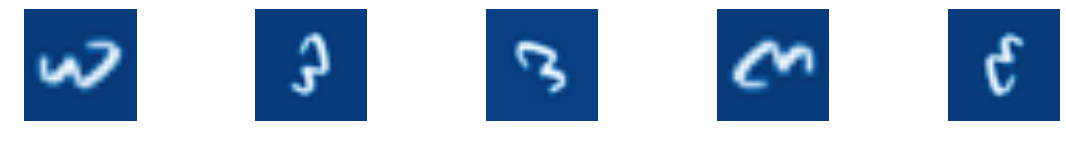

label =  [3]
Neural Network's Prediction =  [3]


In [178]:
random_digit = np.random.randint(test_set_length)
print "random dataset index:", random_digit
#random_digit = 3419
print "Test Set Matrix Accuracy: ", accuracy_test
#print "label = ",ytest[random_digit]
data =  Xtest[random_digit,:]
label = ytest[random_digit]
h=a[len(a)]
y_pred = np.array(np.argmax(h, axis=1) + 1)
data = data.reshape((20, 20))
plt.figure(figsize=(20,2))

for degree in range(5):
    plt.subplot(151+degree)
    rotated_img = scipy.ndimage.rotate(data, degree*60)
    plt.imshow(rotated_img, cmap=plt.cm.Blues_r)
    plt.axis('off')
plt.show()
#print the label provided with the test set:
print "label = ",ytest[random_digit]
#print the network's prediction
print "Neural Network's Prediction = ",y_pred[random_digit] 

Use this code to load a baseline initial theta for testing and development if needed

In [30]:
if 0:
    import pickle
    filename = 'theta_test.pickle'
    with open(filename, 'wb') as handle:
      pickle.dump(theta, handle)

    with open(filename, 'rb') as handle:
      theta2 = pickle.load(handle)

    filename = 'theta_baseline.pickle'
    with open(filename, 'rb') as handle:
      theta_baseline = pickle.load(handle)

#theta_baseline_dic = {1:theta_baseline[0], 2: theta_baseline[1]}